# Tuning hyper parameters 

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from demand_forecasting.read import read_data

# reading voiholm rode data 
rides_raw_df = read_data('../input/voiholm.csv')

# reading weather data
weather_raw_df = read_data('../input/weather_data.csv')

INFO:root:Read dataframe from file path ../input/voiholm.csv
INFO:root:Read dataframe from file path ../input/weather_data.csv


In [2]:
from demand_forecasting.verify import verify_ride_df, verify_weather_df

# verifying the dataframes 
rides_df = verify_ride_df(rides_raw_df)
weather_df = verify_weather_df(weather_raw_df)

INFO:root:Validated Voiholm ride dataframe
INFO:root:Validated weather dataframe


In [3]:
from demand_forecasting.preprocess import preprocessing

df = preprocessing(rides_df=rides_df, weather_df=weather_df)
df

INFO:root:Preprossed dataframe


,h3index_small,start_date,num_of_rides,date,temperature,max_temperature,min_temperature,precipitation,start_weekday
0,891f2506107ffff,2020-08-01,0.0,2020-08-01,17.6,19.3,15.6,0.69,Saturday
1,891f2506107ffff,2020-08-02,0.0,2020-08-02,16.7,19.1,14.8,0.00,Sunday
2,891f2506107ffff,2020-08-03,1.0,2020-08-03,16.8,19.6,14.3,0.00,Monday
3,891f2506107ffff,2020-08-04,2.0,2020-08-04,15.0,17.1,12.8,11.44,Tuesday
4,891f2506107ffff,2020-08-05,2.0,2020-08-05,21.5,26.5,17.0,0.50,Wednesday
...,...,...,...,...,...,...,...,...,...
9775,891f25a9ecbffff,2020-08-26,0.0,2020-08-26,16.7,20.8,13.5,0.00,Wednesday
9776,891f25a9ecbffff,2020-08-27,0.0,2020-08-27,13.9,18.5,9.1,0.60,Thursday
9777,891f25a9ecbffff,2020-08-28,0.0,2020-08-28,14.5,17.8,12.1,0.10,Friday
9778,891f25a9ecbffff,2020-08-29,1.0,2020-08-29,14.7,19.8,8.9,0.00,Saturday


In [18]:
from demand_forecasting.features import generate_features

df_with_features = generate_features(df)
df_with_features

INFO:root:Generating features


,h3index_small,start_date,num_of_rides,date,temperature,max_temperature,min_temperature,precipitation,start_weekday,avg_num_rides_in_area_one_week_before
0,891f2506107ffff,2020-08-01,0.0,2020-08-01,17.6,19.3,15.6,0.69,Saturday,NaN
1,891f2506107ffff,2020-08-02,0.0,2020-08-02,16.7,19.1,14.8,0.00,Sunday,NaN
2,891f2506107ffff,2020-08-03,1.0,2020-08-03,16.8,19.6,14.3,0.00,Monday,NaN
3,891f2506107ffff,2020-08-04,2.0,2020-08-04,15.0,17.1,12.8,11.44,Tuesday,NaN
4,891f2506107ffff,2020-08-05,2.0,2020-08-05,21.5,26.5,17.0,0.50,Wednesday,NaN
...,...,...,...,...,...,...,...,...,...,...
9775,891f25a9ecbffff,2020-08-26,0.0,2020-08-26,16.7,20.8,13.5,0.00,Wednesday,0.285714
9776,891f25a9ecbffff,2020-08-27,0.0,2020-08-27,13.9,18.5,9.1,0.60,Thursday,0.285714
9777,891f25a9ecbffff,2020-08-28,0.0,2020-08-28,14.5,17.8,12.1,0.10,Friday,0.285714
9778,891f25a9ecbffff,2020-08-29,1.0,2020-08-29,14.7,19.8,8.9,0.00,Saturday,0.142857


### Hyper parameter tuning 

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [22]:
# Select target and features: 
target_variable = 'num_of_rides'
features = ['precipitation', 'start_weekday', 'max_temperature', 'avg_num_rides_in_area_one_week_before']

In [23]:
all_feature_df = df_with_features[df_with_features.avg_num_rides_in_area_one_week_before.notna()]

columns = features.copy()
columns.append(target_variable)
model_df = all_feature_df[columns].copy()

model_df['start_weekday'] = model_df.start_weekday.astype("category")

# Setting a side evaluation data to not be used when training and hyper parameter tuning the model
training_df, evaluation_df = train_test_split(model_df, test_size=0.15, random_state=43)

X = training_df.drop(columns=target_variable)
y = training_df[[target_variable]]
X

,precipitation,start_weekday,max_temperature,avg_num_rides_in_area_one_week_before
9351,0.20,Saturday,20.5,2.285714
6479,0.00,Sunday,19.0,0.142857
3651,0.20,Saturday,20.5,6.428571
2358,1.19,Wednesday,24.3,14.428571
885,0.00,Sunday,30.6,9.000000
...,...,...,...,...
8092,0.00,Sunday,18.6,2.714286
3039,0.00,Monday,26.3,9.428571
3010,0.00,Tuesday,26.1,6.428571
4428,1.19,Wednesday,24.3,5.571429


In [25]:
# Deciding which hyperparameters to tune 
max_depths = [2, 3, 4, 5, 6]
learning_rates = [0.01, 0.05, 0.10, 0.15]
n_estimators = [50, 100, 200, 300, 400]

result = []
for max_depth in max_depths: 
    for learning_rate in learning_rates:
        for n_estimator in n_estimators:
            # Defining the model
            xgb_model = xgb.XGBRegressor(enable_categorical=True,
                                         max_depth=max_depth,
                                         learning_rate=learning_rate,
                                         n_estimators=n_estimator,
                                         objective='reg:squarederror', 
                                         booster='gbtree')

            # Defining model evaluation method
            cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(xgb_model, X, y, cv=cv, n_jobs=-1)
            mean_score = scores.mean()
            result.append([max_depth, learning_rate, n_estimator, mean_score])

hyper_parameter_result_df = pd.DataFrame(result, columns=['max_depth', 'learning_rate', 'n_estimator', 'mean_r2_score'])
hyper_parameter_result_df

,max_depth,learning_rate,n_estimator,mean_r2_score
0,2,0.01,50,0.493209
1,2,0.01,100,0.702369
2,2,0.01,200,0.845773
3,2,0.01,300,0.883264
4,2,0.01,400,0.897445
...,...,...,...,...
95,6,0.15,50,0.902883
96,6,0.15,100,0.896523
97,6,0.15,200,0.888064
98,6,0.15,300,0.882851


In [27]:
# Extracting the best combination of hyper parameters and their values 
max_row = hyper_parameter_result_df.loc[hyper_parameter_result_df['mean_r2_score'].idxmax()]
best_depth = int(max_row['max_depth'])
best_learning_rate = float(max_row['learning_rate'])
best_n_estimators = int(max_row['n_estimator'])
best_mean_r2_score = float(max_row['mean_r2_score'])

print('depth:', best_depth, '\n',
      'learning rate:', best_learning_rate, '\n',
      'n estimators:', best_n_estimators, '\n',
      'r2_score:', best_mean_r2_score
      )

# Fitting the model with the best hyper parameters
xgb_best_model = xgb.XGBRegressor(enable_categorical=True,
                                  max_depth=best_depth,
                                    learning_rate=best_learning_rate,
                                    n_estimators=best_n_estimators,
                                    objective='reg:squarederror',
                                    booster='gbtree')
model = xgb_best_model.fit(X, y)

depth: 3 
 learning rate: 0.15 
 n estimators: 50 
 r2_score: 0.9154398115419053


In [16]:
# Evaluating final model on evaluation data
X_evaluation = evaluation_df.drop(columns=target_variable)

# using the trained model to predict values for test data
prediction = model.predict(X_evaluation)
y_true = evaluation_df[['num_of_rides']]

# Creating evaluation dataframe
test_evaulation_df = y_true.copy()
test_evaulation_df['prediction'] = prediction

# forcing negative predictions to be 0 
test_evaulation_df['prediction'] = test_evaulation_df.prediction.map(lambda x: 0 if x < 0 else x)
test_evaulation_df['prediction_int'] = round(test_evaulation_df.prediction, 0)

root_mse = mean_squared_error(test_evaulation_df.num_of_rides, test_evaulation_df.prediction_int, squared=False)
mae = mean_absolute_error(test_evaulation_df.num_of_rides, test_evaulation_df.prediction_int)
r2 = r2_score(test_evaulation_df.num_of_rides, test_evaulation_df.prediction_int)

print('root mse:', root_mse)
print('mae:', mae)
print('r2 score:', r2)

root mse: 7.886979424624135
mae: 4.174222222222222
r2 score: 0.921753207293072


<Axes: >

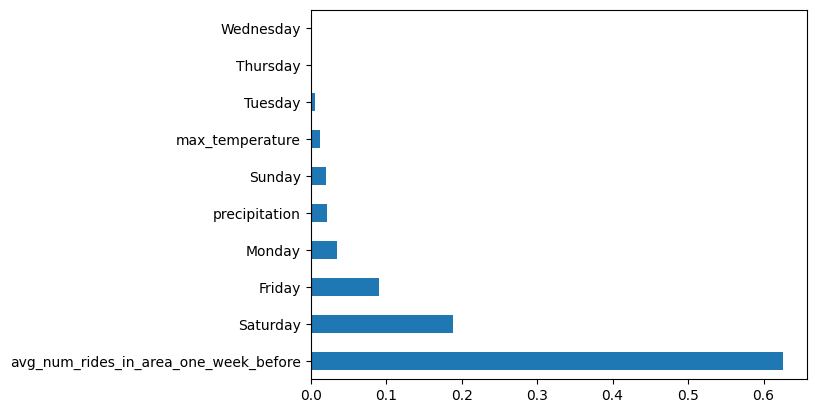

In [12]:
feature_importances = pd.Series(model.feature_importances_, index=list(X.columns))
feature_importances.nlargest(10).plot(kind='barh')